# QC Controldb Samples

Certain Solve 3.7 controldb samples - e.g. NA19440, GM18552 - have too many SVs per sample. 

GM24385 was used as a test sample to build the cohort enrichment workflow, and will be compared against the above samples to verify number of high confidence and rare SVs.

In [167]:
# load packages
from itertools import groupby
from matplotlib_venn import venn2, venn2_circles
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from enrichment_util import *

import copy
import re 
import os
import pathlib
working_dir = pathlib.Path().absolute()
output_dir = "/home/users6/sshukor/enrichment_project/output/controldb_QC/"
os.chdir(working_dir)


%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [168]:
# import helpef functions

# compile full and minimal SV

# Helper function to get smap table without preceding "#..."" lines
def get_sv_from_smap(smap_path):

    with open(smap_path) as file:
        for line in file:
            
            if ('summary' in smap_path):
                if line[0:2] == "#c":
                    header = line[1:].strip()
                    break
                elif line[0:1] == "#":
                    pass

            else:
                if line[0:2] == "#h":
                    header = line[3:].strip()
                    break
                elif line[0:1] == "#":
                    pass

        
        data = [line.strip() for line in file if not line.startswith('#')]

    df = pd.DataFrame([row.split('\t') for row in data])
    df.columns = header.split('\t')[:len(df.columns)]
    return df

# full_df = get_sv_from_smap('/home/users6/sshukor/enrichment_project/output/solve_3_7_controldb/GM24385_dle1_sop/GM24385_dle1_sop_cluster_molecule_variant.txt')
# min_df = get_sv_from_smap('/home/users6/sshukor/enrichment_project/output/solve_3_7_controldb/GM24385_dle1_sop/GM24385_dle1_sop_cluster_molecule_variant_summary.txt')

In [169]:
# helper function to choose largest SV size per cluster, ignoring inversion_paired, and including inversion_partial
def merge_full_and_minimal_clusters(full_df, min_df):
    full_df = full_df.astype({'clusterId':'int','RefcontigID1':'int','RefcontigID2':'int','RefStartPos':'float64','RefEndPos':'float64','SVsize':'float64', 'LinkID':'int','SmapEntryID':'int','Confidence':'float64'})
    min_df = min_df.astype({'clusterId':'int','chrom1':'int','chrom2':'int','position1':'float64','position2':'float64','size':'float64', 'numMembers':'int'})

    # print(full_df.shape)
    # sort clusters and get best representative SV
    full_df = full_df.sort_values(by=['clusterId', 'SVsize'], ascending=[True, False])
    full_df = full_df.groupby('clusterId').first().reset_index()

    # display(full_df), print(full_df.shape)

    # msubset desired columns and rename
    min_df = min_df[['clusterId','chrom1','chrom2','position1','position2','size', 'numMembers']]
    min_df = min_df.rename(columns={'chrom1': 'RefcontigID1', 'chrom2': 'RefcontigID2','size':'SVsize',
                                    'position1':'RefStartPos','position2':'RefEndPos'})

    # merge out_df with cluster_df to change coordincates (min(start):max(end)), median SVsize, and Confidence 
    out_df = pd.merge(full_df, min_df, on='clusterId', suffixes=('_remove', ''))
    out_df = out_df.drop([i for i in out_df.columns if 'remove' in i], axis=1)

    return out_df

# test_out = merge_full_and_minimal_clusters(full_df, min_df)

In [170]:
# load vap .smap, filter out for conf and rare SVs

## Load all 3 sample files

### NA19440

In [171]:
# load NA19440 sample
vap_df = get_sv_from_smap('/home/users6/sshukor/enrichment_project/input/controlsdb_solve3.7/NA19440_vap/variants_combine_filters_inMoleRefine1.smap')
full_df = get_sv_from_smap('/home/users6/sshukor/enrichment_project/output/solve_clustering/NA19440_vap/NA19440_vap_cluster_molecule_variant.txt')
min_df = get_sv_from_smap('/home/users6/sshukor/enrichment_project/output/solve_clustering/NA19440_vap/NA19440_vap_cluster_molecule_variant_summary.txt')
# declare datatypes
print(vap_df.shape, full_df.shape, min_df.shape)
# merge percent controldb - 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme'
full_df = pd.merge(full_df, vap_df[["SmapEntryID", 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme']], how="left", on=["SmapEntryID"])
NA19440_df = merge_full_and_minimal_clusters(full_df, min_df)

# NA19440_df = NA19440_df.loc[~NA19440_df['Type'].str.contains("common|segdupe|nbase", regex=True)]

(15873, 52) (15773, 29) (9781, 11)


In [210]:
vap_df.loc[vap_df['SmapEntryID'] == '27']['Present_in_%_of_BNG_control_samples_with_the_same_enzyme']
# vap_df

13685    97.8
Name: Present_in_%_of_BNG_control_samples_with_the_same_enzyme, dtype: object

In [174]:
full_df.loc[full_df['SmapEntryID'] == '27']

,clusterId,SmapEntryID,QryContigID,RefcontigID1,RefcontigID2,QryStartPos,QryEndPos,RefStartPos,RefEndPos,Confidence,...,GenotypeGroup,RawConfidence,RawConfidenceLeft,RawConfidenceRight,RawConfidenceCenter,SVsize,SVfreq,Orientation,VAF,Present_in_%_of_BNG_control_samples_with_the_same_enzyme
12,8,27,831,1,1,0.0,61381.9,0.0,635339.0,0.99,...,5,3.00,3.00,151.39,3611.99,573957.1,0.5579999999999999,NA,0.2,48.0


In [175]:
NA19440_df.loc[NA19440_df['SmapEntryID'] == 27]

,clusterId,SmapEntryID,QryContigID,QryStartPos,QryEndPos,Confidence,Type,XmapID1,XmapID2,LinkID,...,SVfreq,Orientation,VAF,Present_in_%_of_BNG_control_samples_with_the_same_enzyme,RefcontigID1,RefcontigID2,RefStartPos,RefEndPos,SVsize,numMembers
7,8,27,831,0.0,61381.9,0.99,deletion,11,11,-1,...,0.5579999999999999,NA,0.2,48.0,1,1,0.0,635339.0,573958.0,1


In [176]:
full_df['Type'].value_counts(), NA19440_df['Type'].value_counts()

(insertion                 9811
 deletion                  5259
 inversion_partial          153
 trans_intrachr_common      143
 inversion                  125
 duplication                100
 duplication_inverted        53
 trans_interchr_common       44
 inversion_paired            40
 inversion_nbase             28
 duplication_split            8
 trans_intrachr_segdupe       8
 translocation_intrachr       1
 Name: Type, dtype: int64,
 insertion                 6010
 deletion                  3554
 inversion                   51
 trans_intrachr_common       40
 duplication                 37
 duplication_inverted        29
 trans_interchr_common       29
 inversion_paired            12
 inversion_nbase             10
 duplication_split            6
 trans_intrachr_segdupe       3
 Name: Type, dtype: int64)

### GM24385

In [177]:
# load NA19440 sample
vap_df = get_sv_from_smap('/home/users6/sshukor/enrichment_project/input/controlsdb_solve3.7/GM24385_vap/variants_combine_filters_inMoleRefine1.smap')
full_df = get_sv_from_smap('/home/users6/sshukor/enrichment_project/output/solve_clustering/GM24385_vap/GM24385_vap_cluster_molecule_variant.txt')
min_df = get_sv_from_smap('/home/users6/sshukor/enrichment_project/output/solve_clustering/GM24385_vap/GM24385_vap_cluster_molecule_variant_summary.txt')
# declare datatypes

# merge percent controldb - 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme'
full_df = pd.merge(full_df, vap_df[["SmapEntryID", 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme']], how="left", on=["SmapEntryID"])
GM24385_df = merge_full_and_minimal_clusters(full_df, min_df)


In [178]:
vap_df

,SmapEntryID,QryContigID,RefcontigID1,RefcontigID2,QryStartPos,QryEndPos,RefStartPos,RefEndPos,Confidence,Type,...,num_overlap_DGV_calls,OverlapGenes,NearestNonOverlapGene,NearestNonOverlapGeneDistance,PutativeGeneFusion,Found_in_self_molecules,Self_molecule_count,UCSC_web_link1,UCSC_web_link2,ISCN
0,21,652,1,1,2180001.3,2235547.2,0.0,617119.0,0.99,deletion,...,0,DDX11L1;WASH7P;MIR6859-1;MIR1302-2HG;MIR1302-2...,MTND1P23,11943.0,-,no,0,http://genome.ucsc.edu/cgi-bin/hgTracks?db=hg3...,-,ogm[GRCh38] 1p36.33(0_617119)x0
1,5,651,1,1,2175165.5,2230600.7,0.0,617119.0,0.99,deletion,...,0,DDX11L1;WASH7P;MIR6859-1;MIR1302-2HG;MIR1302-2...,MTND1P23,11943.0,-,no,0,http://genome.ucsc.edu/cgi-bin/hgTracks?db=hg3...,-,ogm[GRCh38] 1p36.33(0_617119)x0
2,552,42,1,1,19697787.3,19707240.9,101280157.0,101289926.0,-1.0,deletion,...,0,-,PPIAP7,8795.0,-,yes,50,http://genome.ucsc.edu/cgi-bin/hgTracks?db=hg3...,-,ogm[GRCh38] 1p21.2(101280157_101289926)x1
3,554,42,1,1,18416485.7,18417241.8,102569837.4,102571110.6,0.85,deletion,...,0,-,AC114485.1,180208.4,-,yes,60,http://genome.ucsc.edu/cgi-bin/hgTracks?db=hg3...,-,ogm[GRCh38] 1p21.1(102569837_102571110)x0
4,666,41,1,1,18382599.1,18383355.2,102569837.4,102571110.6,0.85,deletion,...,0,-,AC114485.1,180208.4,-,yes,56,http://genome.ucsc.edu/cgi-bin/hgTracks?db=hg3...,-,ogm[GRCh38] 1p21.1(102569837_102571110)x0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15925,12477,1681,14,14,-2276.2,674138.6,18898944.0,19189529.0,-1.0,duplication_split,...,102,NF1P7;MED15P1;AL929601.1;AL929601.2;POTEM;AL92...,AL929601.4,8521.0,-,yes,27,http://genome.ucsc.edu/cgi-bin/hgTracks?db=hg3...,-,ogm[GRCh38] dup(14)(q11.2q11.2)
15926,13094,4202,15,15,2058033.9,12478948.9,23280389.0,28424089.5,-1.0,duplication_split,...,0,AC242376.1;AC242376.2;AC100756.3;AC100756.1;GO...,MIR4509-2,2401.5,-,yes,8,http://genome.ucsc.edu/cgi-bin/hgTracks?db=hg3...,-,ogm[GRCh38] dup(15)(q11.2q13.1)
15927,13625,1480,16,16,199951.2,1084806.2,16210691.0,16523720.0,-1.0,duplication_split,...,45,ABCC6;AC136624.1;NOMO3;AC136624.3;AC136624.2;M...,AC136619.2,17497.0,ABCC6-AC136431.1,yes,40,http://genome.ucsc.edu/cgi-bin/hgTracks?db=hg3...,-,ogm[GRCh38] dup(16)(p13.11p13.11)
15928,13683,3130,16,16,-49170.0,403359.2,22600242.0,22708167.0,-1.0,duplication_split,...,3502,AC009021.2;AC009021.1,OTOAP1,23378.0,-,yes,27,http://genome.ucsc.edu/cgi-bin/hgTracks?db=hg3...,-,ogm[GRCh38] dup(16)(p12.2p12.2)


### GM18550

In [179]:
# load NA19440 sample
vap_df = get_sv_from_smap('/home/users6/sshukor/enrichment_project/input/controlsdb_solve3.7/GM18552_vap/variants_combine_filters_inMoleRefine1.smap')
full_df = get_sv_from_smap('/home/users6/sshukor/enrichment_project/output/solve_clustering/GM18552_vap/GM18552_vap_cluster_molecule_variant.txt')
min_df = get_sv_from_smap('/home/users6/sshukor/enrichment_project/output/solve_clustering/GM18552_vap/GM18552_vap_cluster_molecule_variant_summary.txt')
# declare datatypes

# merge percent controldb - 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme'
full_df = pd.merge(full_df, vap_df[["SmapEntryID", 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme']], how="left", on=["SmapEntryID"])
GM18552_df = merge_full_and_minimal_clusters(full_df, min_df)


In [180]:
# vap_df.columns, full_df.columns

In [181]:
# filter for high_confidence and rare SVs

### Calculate % controldb with VAP files and SOlve 3.7 contorldb

In [182]:
def filter_sig_sv(df):
    # output_df = df.loc[df['Sample_ID'].isin(IDs)]
    # percent_controldb_cutoff = 1
    # percent_ctrldb = 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme'
    
    non_masked_df = df.loc[~df['Type'].str.contains("common|segdupe|nbase|trans", regex=True)]    
    sig_df = filter_sig_svs(non_masked_df)
    return sig_df

In [183]:
GM24385_sig_df = filter_sig_sv(GM24385_df)
NA19440_sig_df = filter_sig_sv(NA19440_df)
GM18552_sig_df = filter_sig_sv(GM18552_df)

print(len(GM24385_sig_df), len(NA19440_sig_df), len(GM18552_sig_df))

3928 4286 8087


In [184]:
# add sample name
GM24385_sig_df['Sample_ID'] = 'GM24385_dle1_sop'
NA19440_sig_df['Sample_ID'] = 'NA19440_dle1_sop'
GM18552_sig_df['Sample_ID'] = 'GM18552_dle1_sop'

In [185]:
GM24385_sig_df.to_csv(rf"{output_dir}/GM24385_sig_svs.txt", sep='\t', index=False)
NA19440_sig_df.to_csv(rf"{output_dir}/NA19440_sig_svs.txt", sep='\t', index=False)
GM18552_sig_df.to_csv(rf"{output_dir}/GM18552_sig_svs.txt", sep='\t', index=False)

In [186]:
# load rare SV files
GM24385_rare_df = pd.read_csv(rf"{output_dir}/GM24385_sig_svs_annotated.txt", dtype=object,  index_col=False)
NA19440_rare_df = pd.read_csv(rf"{output_dir}/NA19440_sig_svs_annotated.txt", dtype=object,  index_col=False)
GM18552_rare_df = pd.read_csv(rf"{output_dir}/GM18552_sig_svs_annotated.txt", dtype=object,  index_col=False)

## Analyze rare & high conf SVs

In [187]:
# # output_df = df.loc[df['Sample_ID'].isin(IDs)]
# percent_controldb_cutoff = 1
# percent_ctrldb = 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme'
# sig_df = filter_sig_svs(out_df)
# sig_df = sig_df.astype({percent_ctrldb:"float64"})
# sig_df[percent_ctrldb] = sig_df.apply(lambda x: round(x[percent_ctrldb], 2), axis=1)
# rare_df = sig_df.loc[sig_df[percent_ctrldb] <= percent_controldb_cutoff]

# print(len(out_df), len(sig_df), len(rare_df))

In [188]:
def filter_sig_rare_sv(df, percent_ctrldb_col, percent_controldb_cutoff):
    # output_df = df.loc[df['Sample_ID'].isin(IDs)]
    # percent_controldb_cutoff = 1
    # percent_ctrldb = 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme'
    
    non_masked_df = df.loc[~df['Type'].str.contains("common|segdupe|nbase|trans", regex=True)]
    non_masked_df = non_masked_df.astype({percent_ctrldb_col:"float64"})
    non_masked_df[percent_ctrldb_col] = non_masked_df.apply(lambda x: round(x[percent_ctrldb_col], 2), axis=1)
    
    sig_df = filter_sig_svs(non_masked_df)
    rare_df = sig_df.loc[sig_df[percent_ctrldb_col] <= percent_controldb_cutoff]

    print(len(df), len(non_masked_df), len(sig_df), len(rare_df))
    # return rare_df

In [189]:
def adjust_percent_controldb(val):
    val = float(val)
    
    if val > 0:
        out_val = (round((val/100*179) - 1)/178) * 100
    elif val == 0:
        out_val = 0    
    else:
        return val
    return round(out_val, 1)

adjust_percent_controldb(round(5/179*100))

2.2

In [190]:
round(1.67/100*179)

3

In [191]:
GM24385_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted'] = GM24385_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme'].fillna(0).apply(lambda x: adjust_percent_controldb(x))
NA19440_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted'] = NA19440_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme'].fillna(0).apply(lambda x: adjust_percent_controldb(x))
GM18552_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted'] = GM18552_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme'].fillna(0).apply(lambda x: adjust_percent_controldb(x))

In [192]:
filter_sig_rare_sv(GM24385_df, 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme', 0)
filter_sig_rare_sv(GM24385_df, 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme', 1)

filter_sig_rare_sv(GM24385_df, 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted', 0)
filter_sig_rare_sv(GM24385_df, 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted', 1)

9304 9207 3928 0
9304 9207 3928 2
9304 9207 3928 2
9304 9207 3928 42


In [193]:
filter_sig_rare_sv(NA19440_df, 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme', 0)
filter_sig_rare_sv(NA19440_df, 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme', 1)

filter_sig_rare_sv(NA19440_df, 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted', 0)
filter_sig_rare_sv(NA19440_df, 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted', 1)

9781 9699 4286 5
9781 9699 4286 88
9781 9699 4286 88
9781 9699 4286 142


In [194]:
filter_sig_rare_sv(GM18552_df,  'Present_in_%_of_BNG_control_samples_with_the_same_enzyme', 0)
filter_sig_rare_sv(GM18552_df,  'Present_in_%_of_BNG_control_samples_with_the_same_enzyme', 1)

filter_sig_rare_sv(GM18552_df,  'Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted', 0)
filter_sig_rare_sv(GM18552_df,  'Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted', 1)

15890 15825 8087 1689
15890 15825 8087 3380
15890 15825 8087 3380
15890 15825 8087 3868


In [195]:

filter_sig_rare_sv(GM24385_rare_df,  'percent_controldb', 0)
filter_sig_rare_sv(GM24385_rare_df,  'percent_controldb', 1)

3927 3927 3927 2
3927 3927 3927 36


In [196]:

filter_sig_rare_sv(NA19440_rare_df,  'percent_controldb', 0)
filter_sig_rare_sv(NA19440_rare_df,  'percent_controldb', 1)

4285 4285 4285 81
4285 4285 4285 137


In [197]:
filter_sig_rare_sv(GM18552_rare_df,  'percent_controldb', 0)
filter_sig_rare_sv(GM18552_rare_df,  'percent_controldb', 1)


8087 8087 8087 2975
8087 8087 8087 3753


In [198]:
GM24385_rare_df = GM24385_rare_df.astype({'percent_controldb':'float64', 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme':'float64'})
GM18552_rare_df = GM18552_rare_df.astype({'percent_controldb':'float64', 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme':'float64'})
NA19440_rare_df = NA19440_rare_df.astype({'percent_controldb':'float64', 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme':'float64'})

GM24385_rare_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted'] = GM24385_rare_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme'].fillna(0).apply(lambda x: adjust_percent_controldb(x))
NA19440_rare_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted'] = NA19440_rare_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme'].fillna(0).apply(lambda x: adjust_percent_controldb(x))
GM18552_rare_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted'] = GM18552_rare_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme'].fillna(0).apply(lambda x: adjust_percent_controldb(x))

In [199]:
len(GM24385_rare_df), len(NA19440_rare_df), len(GM18552_rare_df)

(3927, 4285, 8087)

In [200]:
NA19440_rare_df.loc[NA19440_rare_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme'] != 0]

,clusterId,SmapEntryID,QryContigID,QryStartPos,QryEndPos,Confidence,Type,XmapID1,XmapID2,LinkID,...,Present_in_%_of_BNG_control_samples_with_the_same_enzyme,RefcontigID1,RefcontigID2,RefStartPos,RefEndPos,SVsize,numMembers,Sample_ID,percent_controldb,Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted
0,2,4,602,4388811.3,4396977.7,0.9,deletion,2,2,-1,...,14.5,1,1,428120.0,437099.0,813.0,2,NA19440_dle1_sop,13.41,14.0
1,4,13,831,25772.0,49371.2,0.99,insertion,7,7,-1,...,13.4,1,1,365535.0,387230.0,1577.0,3,NA19440_dle1_sop,6.15,12.9
2,5,14,832,30369.0,50567.9,0.98,deletion,8,8,-1,...,7.3,1,1,365535.0,387230.0,1497.0,1,NA19440_dle1_sop,5.59,6.7
3,6,16,3241,300449.6,319250.3,0.99,insertion,9,9,-1,...,3.4,1,1,428120.0,445474.0,1446.0,2,NA19440_dle1_sop,2.23,2.8
4,8,27,831,0.0,61381.9,0.99,deletion,11,11,-1,...,NaN,1,1,0.0,635339.0,573958.0,1,NA19440_dle1_sop,40.78,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4280,9696,15808,751,1041860.8,1041860.8,0.77,inversion,1151,1155,15809,...,97.2,21,21,5605389.0,6215576.0,610188.0,3,NA19440_dle1_sop,100.00,97.2
4281,9697,15822,751,1041860.8,1074861.7,1.0,inversion,1155,1167,15823,...,100.0,21,21,6215576.0,8100606.0,1885031.0,3,NA19440_dle1_sop,100.00,100.0
4282,9703,16784,182,6837822.1,6837822.1,0.9,inversion_paired,1386,1388,16785,...,31.8,23,23,51689302.0,51704032.0,14731.0,2,NA19440_dle1_sop,31.28,31.5
4283,9706,17212,121,68677992.1,68677992.1,1.0,inversion,1408,1411,17213,...,48.6,23,23,141094963.0,141492441.0,383019.0,4,NA19440_dle1_sop,55.87,48.3


## Plot overlap between different controldb calculations

In [201]:
# helper function to plot venn diagram
def plot_venn(subsets, label1, label2, title):
    plt.title(f"{title}", fontsize=12)
    # venn2(subsets = (30, 10, 5), set_labels = ('Group A', 'Group B'), set_colors=('r', 'g'), alpha = 0.5);
    vd = venn2(subsets = subsets, set_labels = (label1, label2), set_colors=('b', 'g'), alpha = 0.5)
    vd.get_label_by_id("10").set_y(0.1)
    vd.get_label_by_id("10").set_x(-0.7)
    vd.get_label_by_id("01").set_x(0.7)
    # vd.get_label_by_id("11").set_y(0.05)
    vd.get_label_by_id("11").set_x(-0.4)
    vd.get_patch_by_id('C').set_ls('dashed')
    vd.get_patch_by_id('C').set_edgecolor('black')
    vd.get_patch_by_id('C').set_lw(1.5)
    # venn2_circles(subsets = subsets)
    plt.show()

def plot_dual_overlap_venn(df, cutoff,case_header,ctrl_header,title, case_label, ctrl_label):

    numCaseOnly = len(df.loc[(df[case_header] <= cutoff) & (df[ctrl_header] > cutoff)])
    numCtrlOnly = len(df.loc[(df[case_header] > cutoff) & (df[ctrl_header] <= cutoff)])
    numShared = len(df.loc[(df[case_header] <= cutoff) & (df[ctrl_header] <= cutoff)])

    plot_venn((numCaseOnly, numCtrlOnly, numShared), f'{case_label}\n# SVs: {numCaseOnly + numShared}', f'{ctrl_label}\n# SVs: {numCtrlOnly + numShared}', title)

In [202]:
COH = 'percent_controldb'
VAP = 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme'
VAP_adj = 'Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted'

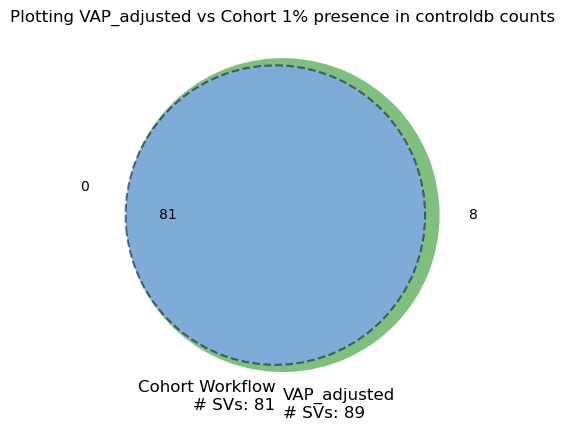

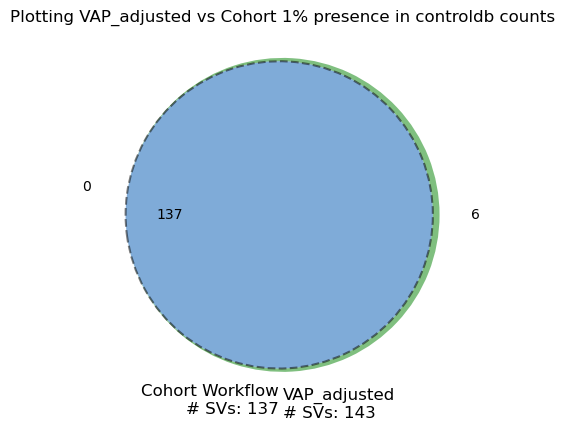

In [203]:
# plot_dual_overlap_venn(NA19440_rare_df, 0, VAP, VAP_adj, "Plotting VAP vs Cohort 0% presence in controldb counts")
plot_dual_overlap_venn(NA19440_rare_df, 0, COH, VAP_adj, "Plotting VAP_adjusted vs Cohort 1% presence in controldb counts", "Cohort Workflow", "VAP_adjusted")
plot_dual_overlap_venn(NA19440_rare_df, 1, COH, VAP_adj, "Plotting VAP_adjusted vs Cohort 1% presence in controldb counts", "Cohort Workflow", "VAP_adjusted")
# plot_dual_overlap_venn(NA19440_rare_df, 0, VAP, COH, "Plotting VAP vs Cohort 0% presence in controldb counts")

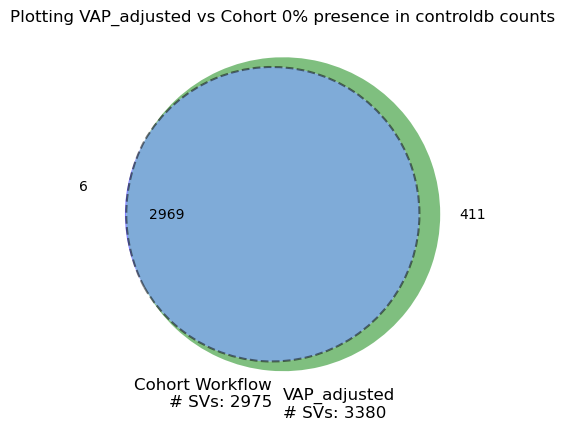

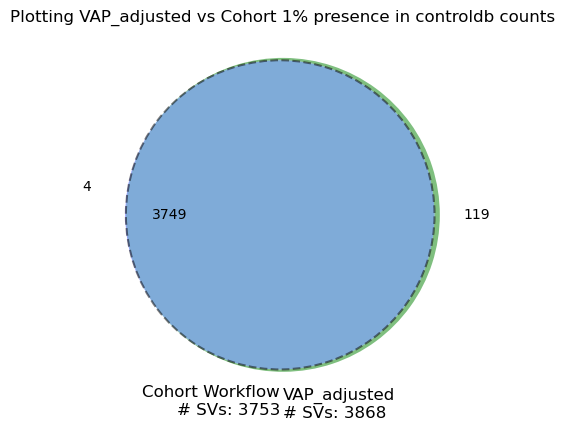

In [204]:
# plot_dual_overlap_venn(GM18552_rare_df, 1, VAP, VAP_adj, "Plotting VAP vs Cohort 1% presence in controldb counts")
plot_dual_overlap_venn(GM18552_rare_df, 0, COH, VAP_adj, "Plotting VAP_adjusted vs Cohort 0% presence in controldb counts", "Cohort Workflow", "VAP_adjusted")
plot_dual_overlap_venn(GM18552_rare_df, 1, COH, VAP_adj, "Plotting VAP_adjusted vs Cohort 1% presence in controldb counts", "Cohort Workflow", "VAP_adjusted")
# plot_dual_overlap_venn(GM18552_rare_df, 1, COH, VAP, "Plotting VAP vs Cohort 1% presence in controldb counts")

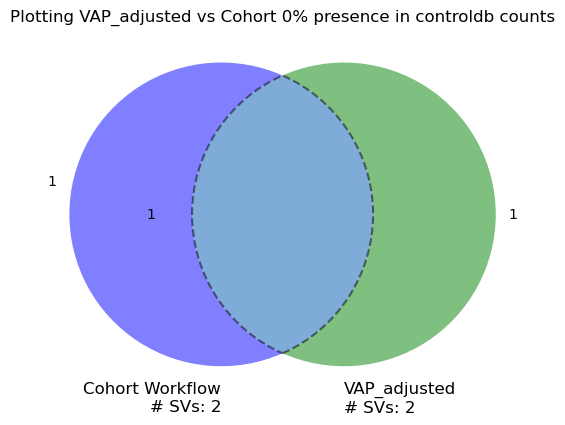

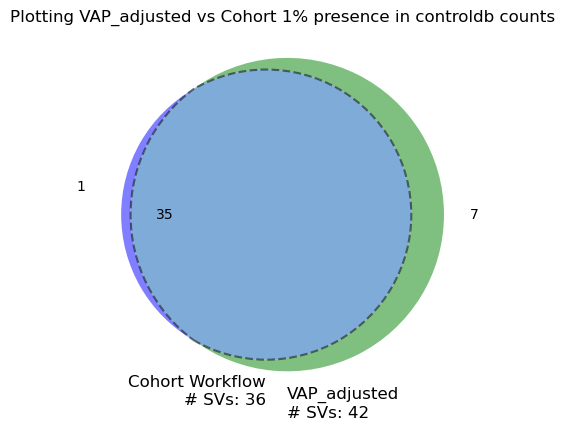

In [205]:
plot_dual_overlap_venn(GM24385_rare_df, 0, COH, VAP_adj, "Plotting VAP_adjusted vs Cohort 0% presence in controldb counts", "Cohort Workflow", "VAP_adjusted")
plot_dual_overlap_venn(GM24385_rare_df, 1, COH, VAP_adj, "Plotting VAP_adjusted vs Cohort 1% presence in controldb counts", "Cohort Workflow", "VAP_adjusted")

Cohort overlaps a lot with VAP

## Proof of adjustment from 5 -> 89 for NA19440

In [209]:
# NA19440_rare_df.loc[(NA19440_rare_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted'] == 0) & (NA19440_rare_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme'] != 0)]['Present_in_%_of_BNG_control_samples_with_the_same_enzyme'].unique()
NA19440_rare_df.loc[(NA19440_rare_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme_adjusted'] == 0) & (NA19440_rare_df['Present_in_%_of_BNG_control_samples_with_the_same_enzyme'] != 0)].to_csv(rf"{output_dir}/NA19440_rare_sv_proof.txt", sep='\t', index=False)

## Recreate approach with full df

In [207]:
NA19440_full_df = get_sv_from_smap('/home/users6/sshukor/enrichment_project/output/solve_clustering/NA19440_vap/NA19440_vap_cluster_molecule_variant.txt')
GM24385_full_df = get_sv_from_smap('/home/users6/sshukor/enrichment_project/output/solve_clustering/GM24385_vap/GM24385_vap_cluster_molecule_variant.txt')
GM18552_full_df = get_sv_from_smap('/home/users6/sshukor/enrichment_project/output/solve_clustering/GM18552_vap/GM18552_vap_cluster_molecule_variant.txt')